<a href="https://colab.research.google.com/github/sondreid/BAN427/blob/master/ban427_google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home Exam
## BAN427: Insurance Analytics

### Importing libraries:

In [53]:
# Modules
import pandas                    as pd
import os
import numpy                     as np
from scipy                   import stats
import seaborn                   as sns
import matplotlib.pyplot         as plt
from sklearn.svm             import SVC
from sklearn.naive_bayes     import GaussianNB
from sklearn                 import model_selection, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics         import confusion_matrix, accuracy_score, recall_score, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.preprocessing   import StandardScaler
from sklearn.linear_model    import LogisticRegression
from sklearn.preprocessing   import OneHotEncoder
from sklearn.neighbors       import KNeighborsClassifier
from matplotlib              import pyplot
from sklearn.ensemble        import RandomForestClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score




### Importing excel data

In [3]:
# Import data from excel to raw_df
raw_df = pd.read_excel("exam_case_data.xlsx")

Adding columns for full churn, partial churn and more sale

In [4]:
# Adding new columns
raw_df['FULL_CHURN']    = np.where(raw_df['TIME2'] != 2, 1, 0)
raw_df['PARTIAL_CHURN'] = np.where((raw_df['NUMBER_COVERS_TIME2'] - raw_df['NUMBER_COVERS_TIME1']) < 0, 1, 0)
raw_df['MORE_SALE']     = np.where((raw_df['NUMBER_COVERS_TIME2'] - raw_df['NUMBER_COVERS_TIME1']) > 0, 1, 0)

# Clean data errors in tenure difference
df = raw_df[(raw_df['TENURE_TIME2'] - raw_df['TENURE_TIME1'] == 0.5) | (raw_df['TIME2']).isnull()]
df.loc[:,'NUMBER_COVERS_TIME2'] = df.loc[:,'NUMBER_COVERS_TIME2'].fillna(0)
df.loc[:,'TOTAL_PREM_TIME2']    = df.loc[:,'TOTAL_PREM_TIME2'].fillna(0)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


## Descriptive Statistics

In [109]:
# Descriptive statistics 
df = pd.DataFrame(df)


# Function for defining age groups
def age_groups(x):
    """'
    Function that outputs  a string denoting an agegroup depending on
    the input integer. 
    """
    if   x < 30:
        return '<30'
    elif x < 40:
        return '<40'
    elif x < 50:
        return '<50'
    elif x < 60:
        return '<60'
    elif x < 70:
        return '<70'
    else:
        return '>=70'

df['AGE_GROUP'] = df['AGE'].apply(age_groups)


In [6]:
# Bivariate consideration
"""def linearplot(Y, df):
  for X in df.columns:
    sns.lmplot(x = X, y = Y, data = df)#, x_estimator = np.mean)

linearplot('FULL_CHURN', df)"""

"def linearplot(Y, df):\n  for X in df.columns:\n    sns.lmplot(x = X, y = Y, data = df)#, x_estimator = np.mean)\n\nlinearplot('FULL_CHURN', df)"

## Descriptive statistics: Tables

In [7]:
# Age table
age_table = df.groupby(by=["AGE_GROUP"]).describe().loc[:,['FULL_CHURN','PARTIAL_CHURN', "MORE_SALE"]]
age_table.style

# Binary variables table
format_table_dict = {'Percentage': '{:.2%}'}
table_binary      = pd.DataFrame([[(df.loc[df['FULL_CHURN'] == 1, 'FULL_CHURN']).count(), (df.loc[df['FULL_CHURN'] == 1, 'FULL_CHURN']).count()/len(df)],
                                 [(df.loc[df['PARTIAL_CHURN'] == 1, 'PARTIAL_CHURN']).count(), (df.loc[df['PARTIAL_CHURN'] == 1, 'PARTIAL_CHURN']).count()/len(df)],
                                 [(df.loc[df['MORE_SALE'] == 1, 'MORE_SALE']).count(), (df.loc[df['MORE_SALE'] == 1, 'MORE_SALE']).count()/len(df)]],
                                 index = ['Full churn (Positive)', 'Partial churn (Positive)', 'More sales (Positive)'],
                                 columns = ["Count", "Percentage"])

table_binary.style.format(format_table_dict)

,Count,Percentage
Full churn (Positive),4391,7.08%
Partial churn (Positive),8162,13.15%
More sales (Positive),5487,8.84%


In [8]:
# Number of covers table
table_continous = pd.DataFrame({'Tenure time 1':(df['TENURE_TIME1']).describe()[1:,], 'Tenure time 2':(df['TENURE_TIME2']).describe()[1:,], 
                                'Number of Covers in period 1': (df['NUMBER_COVERS_TIME1']).describe()[1:,],
                                'Number of Covers in period 2': (df['NUMBER_COVERS_TIME2']).describe()[1:,]
                                })

table_continous.style.format('{:.2f}')

,Tenure time 1,Tenure time 2,Number of Covers in period 1,Number of Covers in period 2
mean,8.21,8.92,8.24,7.67
std,8.90,8.95,6.84,6.92
min,0.00,0.50,1.00,0.00
25%,1.60,2.10,3.00,2.00
50%,5.00,5.70,7.00,6.00
75%,12.20,13.00,12.00,12.00
max,42.40,42.90,215.00,219.00


In [9]:
# Churn and more sales by the size of portfolio 
df['PREMIUM_INCREASE'] = np.where((df['TOTAL_PREM_TIME2'] - df['TOTAL_PREM_TIME1']) > 0, 1, 0)

df.groupby(by=["PREMIUM_INCREASE"]).describe().loc[:,['FULL_CHURN','PARTIAL_CHURN', "MORE_SALE"]]

(df['TOTAL_PREM_TIME2'] - df['TOTAL_PREM_TIME1']).describe()


count    62062.000000
mean      -174.779624
std       1785.179080
min     -38876.000000
25%          0.000000
50%          0.000000
75%        190.000000
max      18977.000000
dtype: float64

In [10]:
# Churn and more sales by whether customers has filed a claim
df.groupby(by = ['CLAIM_EVENT_BEFORE_TIME1']).describe().loc[:,['FULL_CHURN','PARTIAL_CHURN', "MORE_SALE"]]
df.groupby(by = ['AGE_GROUP', 'WOMAN']).describe().loc[:,['FULL_CHURN','PARTIAL_CHURN', "MORE_SALE"]]
df.groupby(by = ['WOMAN', 'AGE_GROUP']).describe().loc[:,['FULL_CHURN','PARTIAL_CHURN', "MORE_SALE"]]


FULL_CHURN                           ... MORE_SALE               
                     count      mean       std  min  ...       25%  50%  75%  max
WOMAN AGE_GROUP                                      ...                         
0     <30           2311.0  0.197317  0.398060  0.0  ...       0.0  0.0  0.0  1.0
      <40           5468.0  0.101317  0.301775  0.0  ...       0.0  0.0  0.0  1.0
      <50           7604.0  0.070095  0.255323  0.0  ...       0.0  0.0  0.0  1.0
      <60           8111.0  0.066823  0.249730  0.0  ...       0.0  0.0  0.0  1.0
      <70           6926.0  0.063962  0.244703  0.0  ...       0.0  0.0  0.0  1.0
      >=70          6599.0  0.056675  0.231239  0.0  ...       0.0  0.0  0.0  1.0
1     <30           1834.0  0.135224  0.342055  0.0  ...       0.0  0.0  0.0  1.0
      <40           3585.0  0.080056  0.271417  0.0  ...       0.0  0.0  0.0  1.0
      <50           5091.0  0.052249  0.222551  0.0  ...       0.0  0.0  0.0  1.0
      <60           5329.0  0.043348  0.203658  0.0  ...       0.0  0.0  0.0  1.0
      <70           4195.0  0.045054  0.207447  0.0  ...       0.0  0.0  0.0  1.0
      >=70          5009.0  0.053504  0.225058  0.0  ...       0.0  0.0  0.0  1.0

[12 rows x 24 columns]

## Descriptive statistics: Plots

In [11]:
sns.set_theme(palette='pastel')
def bar_plot(df, x_var, hue_var, y_var, label_title, x_label, y_label, x_axis_label, y_axis_label):
    """
    Generates a bar plot with hue.
    Parameters:
        df: input dataframeø7609
        x_var : x variable
        hue_var: category variable. Is left out if empty string "". 
        y_var: y variable
        label_title: Title of categories
        x_label:
    """ 
    if hue_var == "":
        ax = sns.barplot(data = df,
                x = x_var, 
                y = y_var)
        ax.set_ylabel(y_axis_label)
        ax.set_xlabel(x_axis_label)
    else: 
        ax = sns.barplot(data = df,
                    x = x_var, 
                    y = y_var, 
                    hue = hue_var)
        ax.set_ylabel(y_axis_label)
        ax.set_xlabel(x_axis_label)
        labels = [x_label, y_label]
        h, l = ax.get_legend_handles_labels()
        ax.legend(h, labels, title = label_title)
    return ax


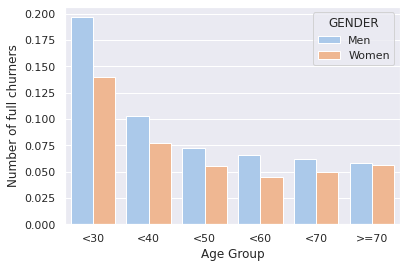

In [12]:
# FULL CHURNERS
hist_df_full_churn_no_claim            = df.loc[df.CLAIM_EVENT_BEFORE_TIME1 == 0, ['FULL_CHURN','AGE_GROUP', 'WOMAN']].groupby(by = ["AGE_GROUP", 'WOMAN']).mean()
hist_df_full_churn_no_claim.index.name = 'AGE_GROUP'
hist_df_full_churn_no_claim.reset_index(inplace=True)

bar_plot(hist_df_full_churn_no_claim, 
         "AGE_GROUP", 
         'WOMAN', 
         'FULL_CHURN', 
         'GENDER', 
         'Men', 
         'Women', 
         'Age Group', 
         'Number of full churners')


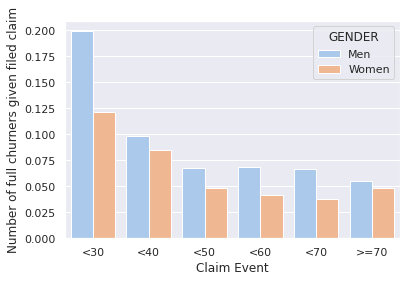

In [13]:
# FULL CHURNERS given claim
hist_df_full_churn_given_claim = df.loc[df.CLAIM_EVENT_BEFORE_TIME1 == 1,['FULL_CHURN','AGE_GROUP', 'WOMAN']].groupby(by = ["AGE_GROUP", 'WOMAN']).mean()
hist_df_full_churn_given_claim.index.name = 'AGE_GROUP'
hist_df_full_churn_given_claim.reset_index(inplace=True)

bar_plot(hist_df_full_churn_given_claim, "AGE_GROUP", 'WOMAN', 'FULL_CHURN', 'GENDER', 'Men', 'Women', 'Claim Event', 'Number of full churners given filed claim' )


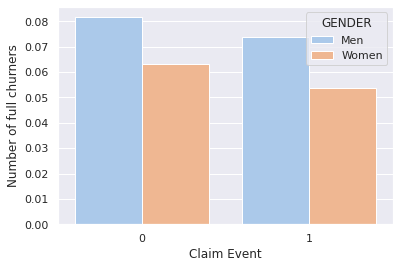

In [14]:
# FULL CHURN by claim event 
hist_df_full_claim_event = df.loc[:,['FULL_CHURN','CLAIM_EVENT_BEFORE_TIME1', 'WOMAN']].groupby(by = ['CLAIM_EVENT_BEFORE_TIME1', 'WOMAN']).mean()
hist_df_full_claim_event.index.name = 'CLAIM_EVENT_BEFORE_TIME1'
hist_df_full_claim_event.reset_index(inplace=True)

bar_plot(hist_df_full_claim_event, "CLAIM_EVENT_BEFORE_TIME1", 'WOMAN', 'FULL_CHURN', 'GENDER', 'Men', 'Women', 'Claim Event', 'Number of full churners' )


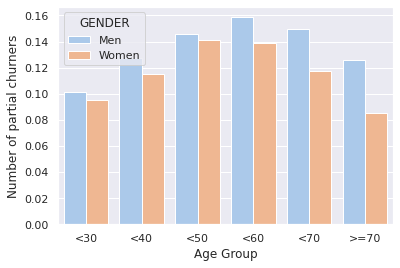

In [15]:
# PARTIAL CHURNERS
hist_df_partial_churn = df.loc[:,['PARTIAL_CHURN','AGE_GROUP', 'WOMAN']].groupby(by = ["AGE_GROUP", 'WOMAN']).mean()
hist_df_partial_churn.index.name = 'AGE_GROUP'
hist_df_partial_churn.reset_index(inplace=True)

# Partial plot
bar_plot(hist_df_partial_churn, "AGE_GROUP", 'WOMAN', 'PARTIAL_CHURN', 'GENDER', 'Men', 'Women', 'Age Group', 'Number of partial churners' )


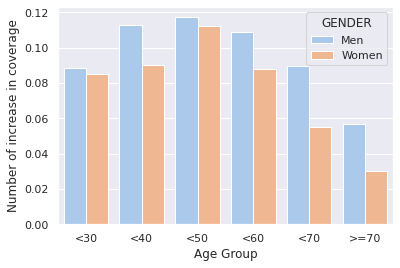

In [16]:
# MORE SALE
hist_df_more_sale = df.loc[:,['MORE_SALE','AGE_GROUP', 'WOMAN']].groupby(by = ["AGE_GROUP", 'WOMAN']).mean()
hist_df_more_sale.index.name = 'AGE_GROUP'
hist_df_more_sale.reset_index(inplace=True)

# More sales plot
bar_plot(hist_df_more_sale, "AGE_GROUP", 'WOMAN', 'MORE_SALE', 'GENDER', 'Men', 'Women', 'Age Group', 'Number of increase in coverage' )


## Prediction models: Treating data

In [122]:

# Creating features and prediction variables
x   = df.loc[:, ~df.columns.isin(['TIME1', 'NUMBER_COVERS_TIME2', 
'PREMIUM_INCREASE', 'TIME2', 'TOTAL_PREM_TIME2', 'AVERAGE_INCOME_COUNTY_TIME1','TENURE_TIME2','FULL_CHURN', 'PARTIAL_CHURN', 'MORE_SALE'])]



## One hot encoding age group feature
one_hot_encoder = OneHotEncoder(handle_unknown= 'ignore')

one_hot_encoder.fit(df[['AGE_GROUP']])

age_group_hot = one_hot_encoder.transform(df[['AGE_GROUP']]).toarray()
age_group_hot

age_group_hot_df = pd.DataFrame(age_group_hot)
age_group_hot_df.columns = one_hot_encoder.get_feature_names()

# Concat into x
x = pd.concat([x.reset_index(drop=True), age_group_hot_df], axis=1)
x = x[x.columns.difference(['AGE', 'AGE_GROUP'])] # Remove string AGE_GROUP


# Check for NaN
x[x.isna().any(axis=1)]


y_full_churn    = df['FULL_CHURN']
y_partial_churn = df['PARTIAL_CHURN']
y_more_sale     = df['MORE_SALE']



def variable_importance(model):
    """"
    Function that takes a fitted model and enumerates its features' importance.
    Prints a barplot
    parameters:
        @model: fitted model
    """
    importance = model.coef_[0]
    for i,v in enumerate(importance):
            print('Feature: %0d, Score: %.5f' % (i,v))
    
    pyplot.bar([x for x in range(len(importance))], importance)
    pyplot.show()
    

def roc(ytrain, x_train, ytest, x_test, model):
    """
    Function that draws a ROC curve based o
    Parameters:
        @ytrain: target feature training set
        @x_train: features training set
        @y_test: target feature test set
        @x_test: features test set
        @model: a fitted model
    """
    fit_proba = model.predict_proba(x_train)
    yprob_pred = model.predict_proba(x_test)

    fpr, tpr, tr = metrics.roc_curve(ytest, yprob_pred[:,1])
    auc = metrics.roc_auc_score(ytest, yprob_pred[:, 1])

    fpr1, tpr1, tr = metrics.roc_curve(ytrain, fit_proba[:,1])
    auc1 = metrics.roc_auc_score(ytrain, fit_proba[:,1])

    plt.figure(num = None, figsize = (10,10), dpi = 80)
    plt.plot((1,0), (1,0), ls = "--", c = ".3")
    plt.xlabel('False positive rate')
    plt.plot(fpr, tpr, label = '{} test data (area = {:.2f})'.format(model, auc))
    plt.plot(fpr1, tpr1, label = '{} train data (area = {:.2f})'.format(model, auc1))
    plt.ylabel('True positive rate')
    plt.legend()
    plt.title(' ROC Curve - test and train data')
    plt.show()
    return plt



def clear_conf_matrix(test_set, prediction_set, title):
  """ 
  Creates and renders a confusion matrix 
  Parameters:
    @test_set: dataset containing test data
    @prediction_set: dataset containing predictions produced by model
    @title: String, title in rendered plot
  """
  matrix = confusion_matrix(test_set, prediction_set)
  matrix_display = ConfusionMatrixDisplay(matrix, display_labels=['0','1'])
  matrix_display.plot(cmap='BuGn', values_format = '.0f')
  matrix_display.ax_.set(
                title= title)
  plt.show()


In [113]:
# Splitting the data into train and test [fc = full churn, pc = partial churn, ms = more sales]

xtrain_fc, xtest_fc, ytrain_fc, ytest_fc = train_test_split(x, y_full_churn,    test_size = 0.2, random_state = 0)
xtrain_pc, xtest_pc, ytrain_pc, ytest_pc = train_test_split(x, y_partial_churn, test_size = 0.2, random_state = 0)
xtrain_ms, xtest_ms, ytrain_ms, ytest_ms = train_test_split(x, y_more_sale,     test_size = 0.2, random_state = 0)

In [19]:
# Scaling the features

sc = StandardScaler()

xtrain_fc = sc.fit_transform(xtrain_fc)
xtest_fc  = sc.transform(xtest_fc)

xtrain_pc = sc.fit_transform(xtrain_pc)
xtest_pc  = sc.transform(xtest_pc)

xtrain_ms = sc.fit_transform(xtrain_ms)
xtest_ms  = sc.transform(xtest_ms)




## Logistic regression model

### Training the logistic regression model

In [20]:


logreg_fc = LogisticRegression(random_state = 0)
logreg_fc.fit(xtrain_fc, ytrain_fc)

logreg_pc = LogisticRegression(random_state = 0)
logreg_pc.fit(xtrain_pc, ytrain_pc)

logreg_ms = LogisticRegression(random_state = 0)
logreg_ms.fit(xtrain_ms, ytrain_ms)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
# Predicting the logreg model
ypred_logreg_fc = logreg_fc.predict(xtest_fc)
yprob_logreg_fc = (logreg_fc.predict_proba(xtest_fc)[:,1]  >= 0.05).astype(bool)

ypred_logreg_pc = logreg_pc.predict(xtest_pc)
yprob_logreg_pc = (logreg_pc.predict_proba(xtest_pc)[:,1]  >= 0.05).astype(bool)

ypred_logreg_ms = logreg_ms.predict(xtest_ms)
yprob_logreg_ms = (logreg_pc.predict_proba(xtest_ms)[:,1]  >= 0.05).astype(bool)



### Variable importance Logistic regression

Feature: 0, Score: -0.19060
Feature: 1, Score: 0.10377
Feature: 2, Score: 0.07769
Feature: 3, Score: -0.16235
Feature: 4, Score: -0.55141
Feature: 5, Score: -0.18163
Feature: 6, Score: -0.38815
Feature: 7, Score: 0.31959
Feature: 8, Score: 0.07811
Feature: 9, Score: -0.18987
Feature: 10, Score: 0.13427
Feature: 11, Score: 0.05711
Feature: 12, Score: -0.02684
Feature: 13, Score: -0.04401
Feature: 14, Score: -0.02516
Feature: 15, Score: -0.03898


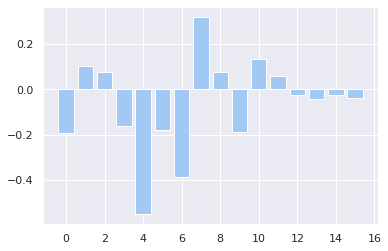

In [102]:
# Variable importance  
#FC 
variable_importance(logreg_fc)



## KNN model

### Training the KNN-model

In [24]:

knn_fc = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn_fc.fit(xtrain_fc, ytrain_fc)

knn_pc = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn_pc.fit(xtrain_pc, ytrain_pc)

knn_ms = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn_ms.fit(xtrain_ms, ytrain_ms)

# Predicting the knn models


ypred_knn_pc = knn_pc.predict(xtest_pc)

ypred_knn_ms = knn_ms.predict(xtest_ms)


### Training the SVM-model

In [26]:
"""

svc_fc = SVC(kernel = 'rbf', random_state = 0, probability = True)
svc_fc.fit(xtrain_fc, ytrain_fc)

svc_pc = SVC(kernel = 'rbf', random_state = 0, probability = True)
svc_pc.fit(xtrain_pc, ytrain_pc)

svc_ms = SVC(kernel = 'rbf', random_state = 0, probability = True)
svc_ms.fit(xtrain_ms, ytrain_ms)

# Predicting the svm model
ypred_svc_fc = (svc_fc.predict_proba(xtest_fc)[:,1]  >= 0.05).astype(bool)
ypred_svc_pc = (svc_pc.predict_proba(xtest_pc)[:,1]  >= 0.05).astype(bool)
ypred_svc_ms = (svc_ms.predict_proba(xtest_ms)[:,1]  >= 0.05).astype(bool)

# Checking the accuracy with confusion matrix
cm_svc_fc = confusion_matrix(ytest_fc, ypred_svc_fc)
print(cm_svc_fc)
accuracy_score(ytest_fc, ypred_svc_fc)

cm_svc_pc = confusion_matrix(ytest_pc, ypred_svc_pc)
print(cm_svc_pc)
accuracy_score(ytest_pc, ypred_svc_pc)

cm_svc_ms = confusion_matrix(ytest_ms, ypred_svc_ms)
print(cm_svc_ms)
accuracy_score(ytest_ms, ypred_svc_ms)



#ROC Curve SVM
roc_SVM_fc = roc(ytrain_fc, xtrain_fc, ytest_fc, xtest_fc, svc_fc)
roc_SVM_fc

roc_SVM_pc = roc(ytrain_pc, ytest_pc, ypred_svc_pc)
roc_SVM_pc

roc_SVM_ms = roc(ytrain_ms, ytest_ms, ypred_svc_ms)
roc_SVM_ms
"""


"\n\nsvc_fc = SVC(kernel = 'rbf', random_state = 0, probability = True)\nsvc_fc.fit(xtrain_fc, ytrain_fc)\n\nsvc_pc = SVC(kernel = 'rbf', random_state = 0, probability = True)\nsvc_pc.fit(xtrain_pc, ytrain_pc)\n\nsvc_ms = SVC(kernel = 'rbf', random_state = 0, probability = True)\nsvc_ms.fit(xtrain_ms, ytrain_ms)\n\n# Predicting the svm model\nypred_svc_fc = (svc_fc.predict_proba(xtest_fc)[:,1]  >= 0.05).astype(bool)\nypred_svc_pc = (svc_pc.predict_proba(xtest_pc)[:,1]  >= 0.05).astype(bool)\nypred_svc_ms = (svc_ms.predict_proba(xtest_ms)[:,1]  >= 0.05).astype(bool)\n\n# Checking the accuracy with confusion matrix\ncm_svc_fc = confusion_matrix(ytest_fc, ypred_svc_fc)\nprint(cm_svc_fc)\naccuracy_score(ytest_fc, ypred_svc_fc)\n\ncm_svc_pc = confusion_matrix(ytest_pc, ypred_svc_pc)\nprint(cm_svc_pc)\naccuracy_score(ytest_pc, ypred_svc_pc)\n\ncm_svc_ms = confusion_matrix(ytest_ms, ypred_svc_ms)\nprint(cm_svc_ms)\naccuracy_score(ytest_ms, ypred_svc_ms)\n\n\n\n#ROC Curve SVM\nroc_SVM_fc = roc

## Naive bayes model

### Training the Naive bayes model

In [112]:


nb_fc = GaussianNB()
nb_fc.fit(xtrain_fc, ytrain_fc)

nb_pc = GaussianNB()
nb_pc.fit(xtrain_pc, ytrain_pc)

nb_ms = GaussianNB()
nb_ms.fit(xtrain_ms, ytrain_ms)



GaussianNB(priors=None, var_smoothing=1e-09)

### SVM-model with 'AVERAGE_INCOME_COUNTY_TIME1

In [28]:
"""
df_avg_income = df[df['AVERAGE_INCOME_COUNTY_TIME1'].notna()]

y_full_churn_avg_income   = df_avg_income['FULL_CHURN']
xtrain_avg_income, xtest_avg_income, ytrain_avg_income, ytest_avg_income = train_test_split(x_avg_income, y_full_churn_avg_income, test_size = 0.2, random_state = 0)

svc_fc = SVC(kernel = 'rbf', random_state = 0, probability = True)
svc_fc.fit(xtrain_avg_income, ytrain_avg_income)

# Predicting the svm model
ypred_svc_avg_income = (svc_fc.predict_proba(xtest_avg_income)[:,1]  >= 0.05).astype(bool)

# Checking the accuracy with confusion matrix
cm_svc_avg_income = confusion_matrix(ytest_avg_income, ypred_svc_avg_income)
print(cm_svc_avg_income)
accuracy_score(ytest_avg_income, ypred_svc_avg_income)
"""

"\ndf_avg_income = df[df['AVERAGE_INCOME_COUNTY_TIME1'].notna()]\n\ny_full_churn_avg_income   = df_avg_income['FULL_CHURN']\nxtrain_avg_income, xtest_avg_income, ytrain_avg_income, ytest_avg_income = train_test_split(x_avg_income, y_full_churn_avg_income, test_size = 0.2, random_state = 0)\n\nsvc_fc = SVC(kernel = 'rbf', random_state = 0, probability = True)\nsvc_fc.fit(xtrain_avg_income, ytrain_avg_income)\n\n# Predicting the svm model\nypred_svc_avg_income = (svc_fc.predict_proba(xtest_avg_income)[:,1]  >= 0.05).astype(bool)\n\n# Checking the accuracy with confusion matrix\ncm_svc_avg_income = confusion_matrix(ytest_avg_income, ypred_svc_avg_income)\nprint(cm_svc_avg_income)\naccuracy_score(ytest_avg_income, ypred_svc_avg_income)\n"

### Gradient boosting machine

In [108]:

gbm_fc = GradientBoostingClassifier()
gbm_fc = gbm_fc.fit(xtrain_fc, ytrain_fc)


gbm_pc = GradientBoostingClassifier()
gbm_pc = gbm_fc.fit(xtrain_pc, ytrain_pc)

gbm_ms = GradientBoostingClassifier()
gbm_ms = gbm_fc.fit(xtrain_ms, ytrain_ms)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(gbm_fc, xtrain_fc, ytrain_fc, scoring='recall', cv=cv, n_jobs=-1, error_score='raise')


#### GBM CV output

In [107]:

print('Recall CV average: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))



Recall CV average: 0.101 (0.017)


## LDA model

### Training the LDA model

In [115]:

lda_fc = LinearDiscriminantAnalysis()
lda_fc.fit(xtrain_fc, ytrain_fc)

lda_pc = LinearDiscriminantAnalysis()
lda_pc.fit(xtrain_pc, ytrain_pc)

lda_ms = LinearDiscriminantAnalysis()
lda_ms.fit(xtrain_fc, ytrain_ms)

## Find parameters

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 10, random_state = 1)
grid = dict()
grid['solver'] = ['svd', 'lsqr', 'eigen']

search = GridSearchCV(lda_fc, grid, scoring='roc_auc', cv=cv, n_jobs= 8)




### Results from CV

In [ ]:
#scores = cross_val_score(lda_fc, )

results = search.fit(xtrain_fc, ytrain_fc)
# summarize
print('Mean Accuracy CV: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)



## Random Forest model

### Traning the Random Forest model

In [110]:

rfc_fc = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
rfc_fc = rfc_fc.fit(xtrain_fc, ytrain_fc)

rfc_pc = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
rfc_pc = rfc_pc.fit(xtrain_pc, ytrain_pc)

rfc_ms = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
rfc_ms = rfc_ms.fit(xtrain_ms, ytrain_ms)


### Optimal treshold: Probably not used

In [ ]:
from numpy import sqrt, argmax, isnan

lda_treshold_preds = (lda_fc.predict_proba(xtest_fc))[:,1]
log_treshold_preds = logreg_fc.predict_proba(xtest_fc)[:,1]
print(np.isnan((sum(lda_treshold_preds))))

print(len(ytest_fc), "  ", len(log_treshold_preds))
precision, recall, thresholds = metrics.precision_recall_curve(ytest_fc, lda_treshold_preds)
#fpr, tpr, thresholds = metrics.roc_curve(ytest_fc, log_treshold_preds)
#gmeans = sqrt(tpr * (1-fpr))
#J = tpr-fpr


# convert to f score
#fscore = (2*precision*recall)/(precision + recall)
#fscore = fscore[~isnan(fscore)]
#print(fscore)

ix = argmax(recall)
print('Best Threshold=%f, fscore =%.3f' % (thresholds[ix], recall[ix]))


# Comparing models

### Full churn

RECALL NB: 0.654
Accuracy NB: 0.553


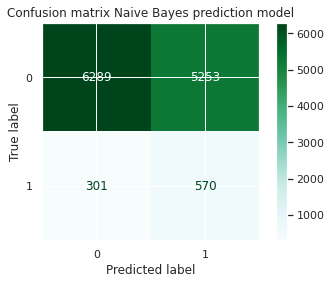

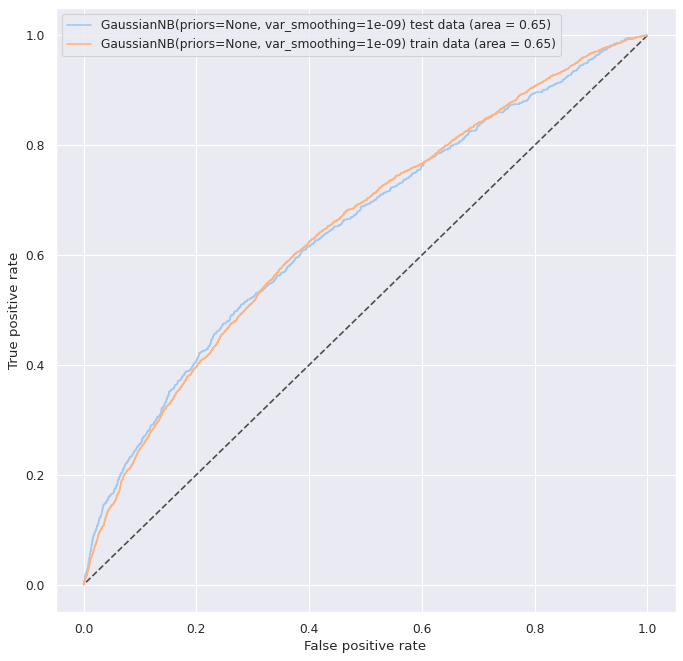

RECALL NB: 0.410
Accuracy NB: 0.709


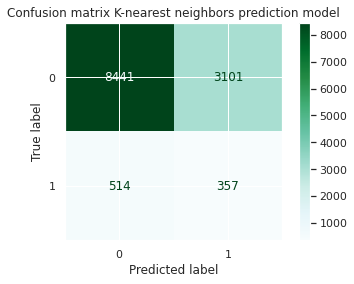

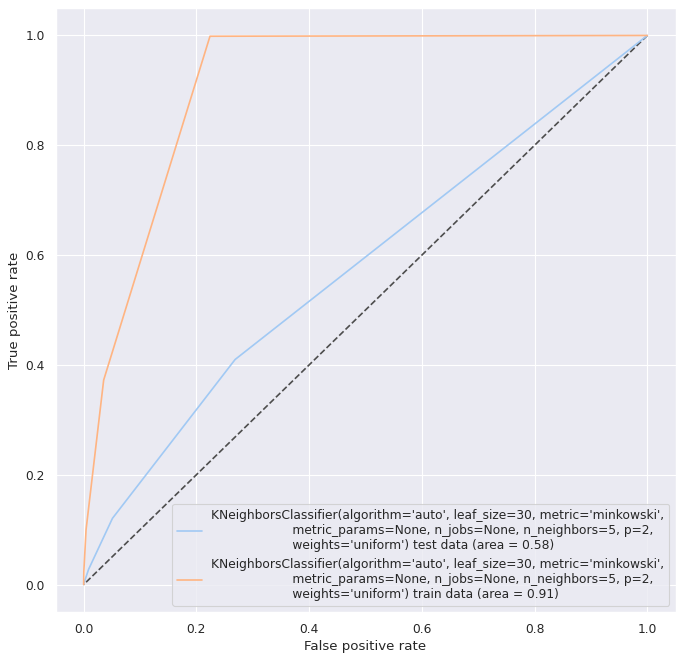

RECALL RF: 0.788
Accuracy RF: 0.434


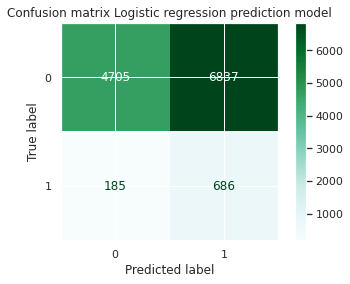

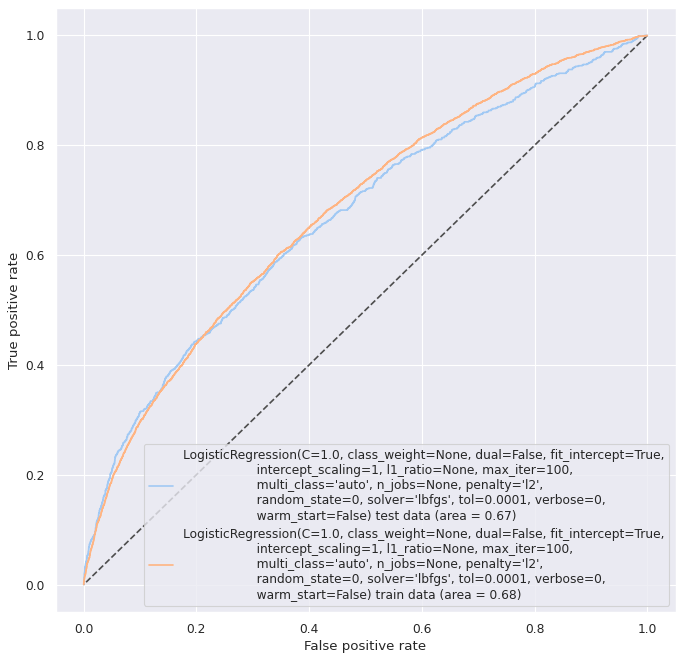

RECALL RF: 0.555
Accuracy RF: 0.621


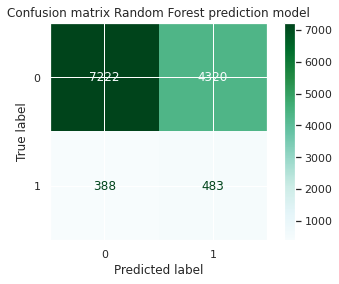

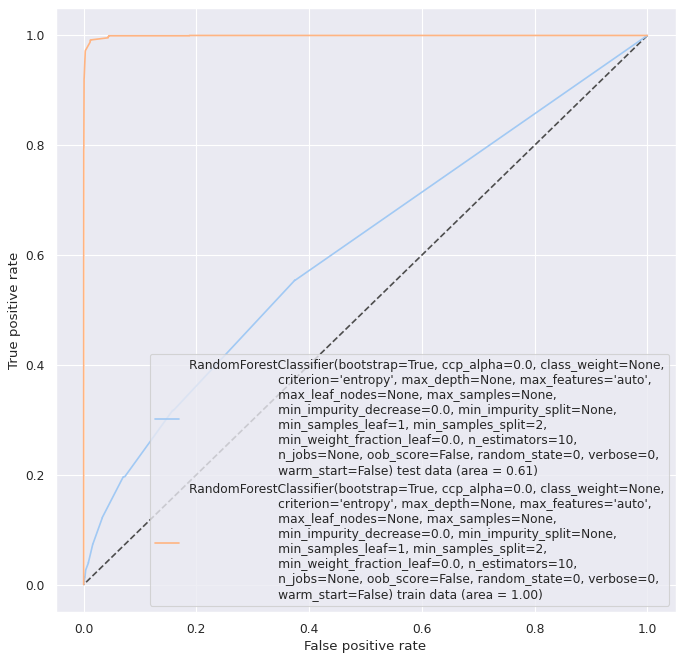

RECALL LDA: 0.437
Accuracy LDA: 0.766


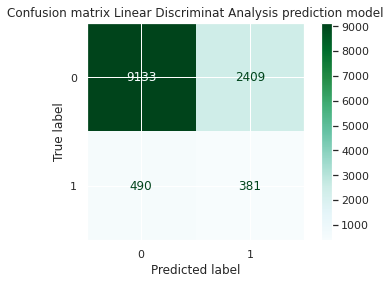

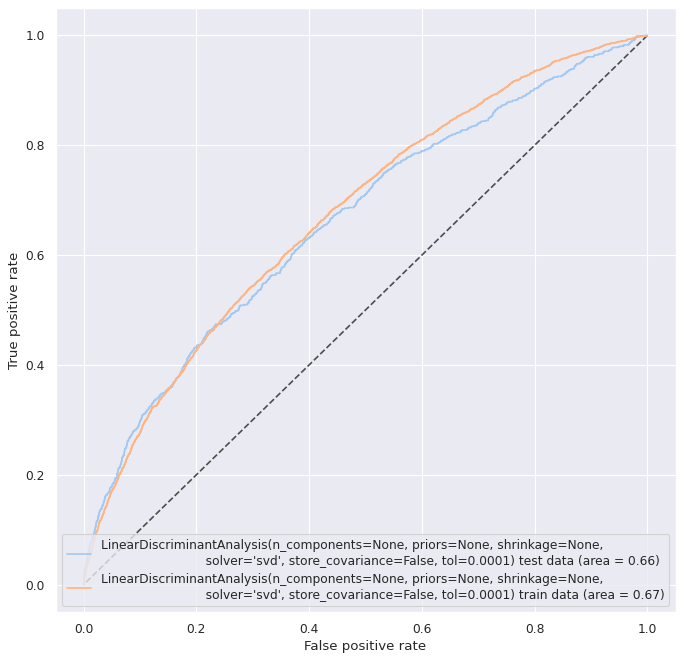

RECALL GBM: 0.808
Accuracy GBM: 0.488


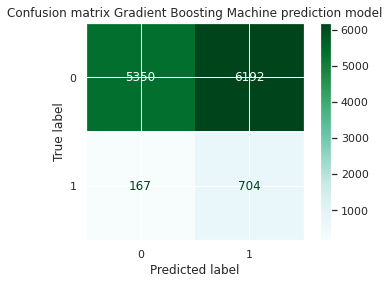

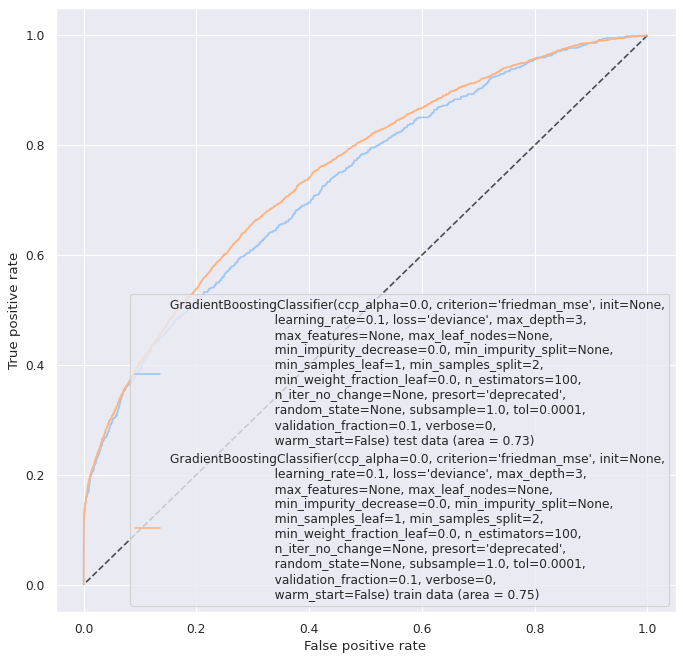

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [105]:
## Naive Bayes 
ypred_nb_fc = (nb_fc.predict_proba(xtest_fc)[:,1]  >= 0.05).astype(bool)
print('RECALL NB: %.3f' % recall_score(ytest_fc, ypred_nb_fc))
print('Accuracy NB: %.3f' % accuracy_score(ytest_fc, ypred_nb_fc))
clear_conf_matrix(ytest_fc, ypred_nb_fc, 'Confusion matrix Naive Bayes prediction model')
roc(ytrain_fc, xtrain_fc, ytest_fc, xtest_fc, nb_fc)


## KNN
ypred_knn_fc = (knn_fc.predict_proba(xtest_fc)[:,1]  >= 0.01).astype(bool)
print('RECALL NB: %.3f' % recall_score(ytest_fc, ypred_knn_fc))
print('Accuracy NB: %.3f' % accuracy_score(ytest_fc, ypred_knn_fc))
clear_conf_matrix(ytest_fc, ypred_knn_fc, 'Confusion matrix K-nearest neighbors prediction model')
roc(ytrain_fc, xtrain_fc, ytest_fc, xtest_fc, knn_fc)

## Logistic regression
yprob_logreg_fc = (logreg_fc.predict_proba(xtest_fc)[:,1]  >= 0.05).astype(bool)
print('RECALL RF: %.3f' % recall_score(ytest_fc, yprob_logreg_fc))
print('Accuracy RF: %.3f' % accuracy_score(ytest_fc, yprob_logreg_fc))
clear_conf_matrix(ytest_fc, yprob_logreg_fc, 'Confusion matrix Logistic regression prediction model')
roc(ytrain_fc, xtrain_fc, ytest_fc, xtest_fc, logreg_fc)

### Random forest

ypred_rfc_fc = (rfc_fc.predict_proba(xtest_fc)[:,1] > 0.05).astype(bool)
print('RECALL RF: %.3f' % recall_score(ytest_fc, ypred_rfc_fc))
print('Accuracy RF: %.3f' % accuracy_score(ytest_fc, ypred_rfc_fc))
clear_conf_matrix(ytest_fc, ypred_rfc_fc, 'Confusion matrix Random Forest prediction model')
roc(ytrain_fc, xtrain_fc, ytest_fc, xtest_fc, rfc_fc)

### LDA

ypred_lda_fc = (lda_fc.predict_proba(xtest_fc)[:,1]  >= 0.087912).astype(bool)
print('RECALL LDA: %.3f' % recall_score(ytest_fc, ypred_lda_fc))
print('Accuracy LDA: %.3f' % accuracy_score(ytest_fc, ypred_lda_fc))
clear_conf_matrix(ytest_fc, ypred_lda_fc, 'Confusion matrix Linear Discriminat Analysis prediction model')
roc(ytrain_fc, xtrain_fc, ytest_fc, xtest_fc, lda_fc)


#### GBM
ypred_gbm_fc = (gbm_fc.predict_proba(xtest_fc)[:,1]  >= 0.05).astype(bool)
print('RECALL GBM: %.3f' % recall_score(ytest_fc, ypred_gbm_fc))
print('Accuracy GBM: %.3f' % accuracy_score(ytest_fc, ypred_gbm_fc))
clear_conf_matrix(ytest_fc, ypred_gbm_fc, 'Confusion matrix Gradient Boosting Machine prediction model')
roc(ytrain_fc, xtrain_fc, ytest_fc, xtest_fc, gbm_fc)



## Partial churn

RECALL NB: 1.000
Accuracy NB: 0.137


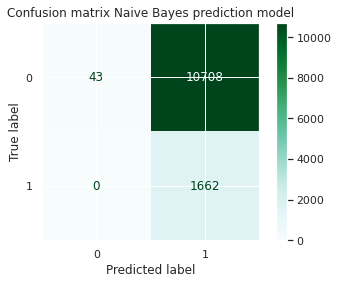

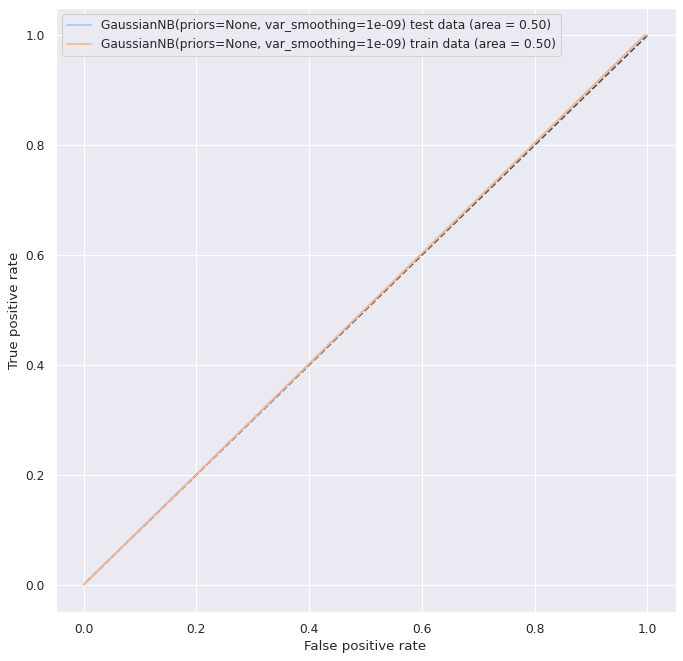

RECALL NB: 1.000
Accuracy NB: 0.136


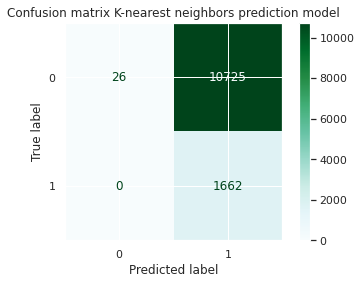

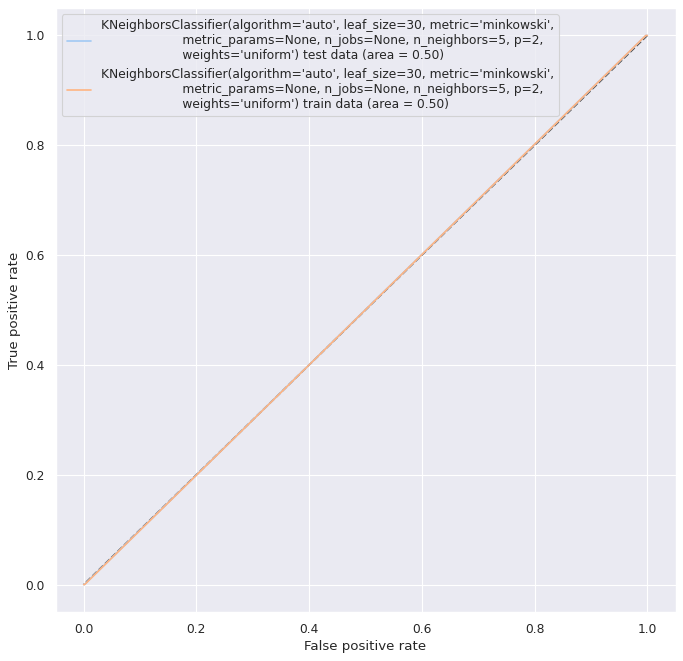

RECALL RF: 0.000
Accuracy RF: 0.855


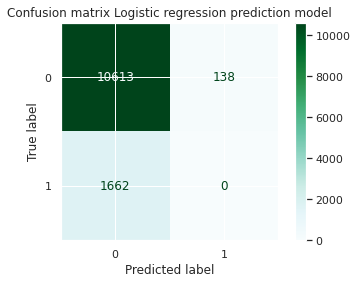

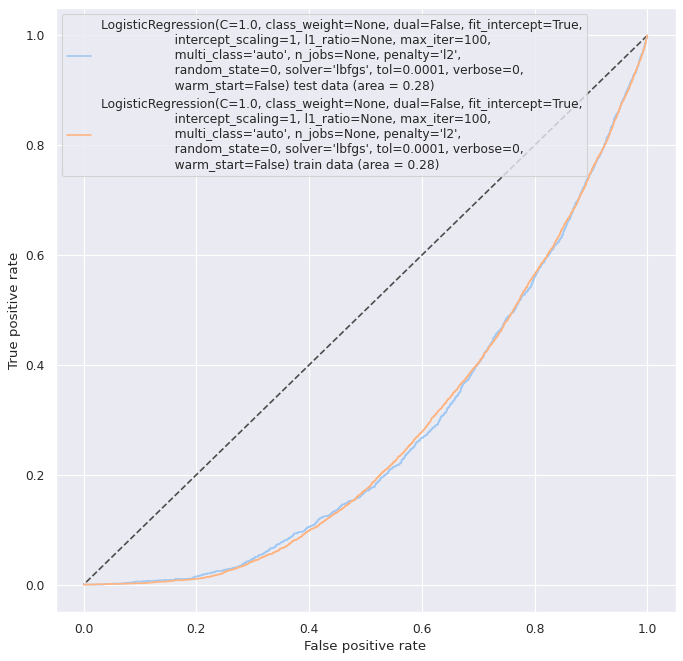

RECALL RF: 0.897
Accuracy RF: 0.199


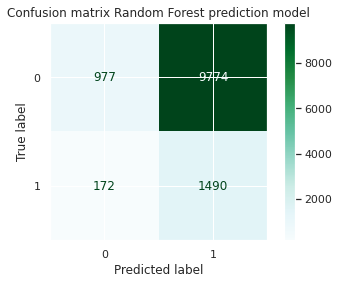

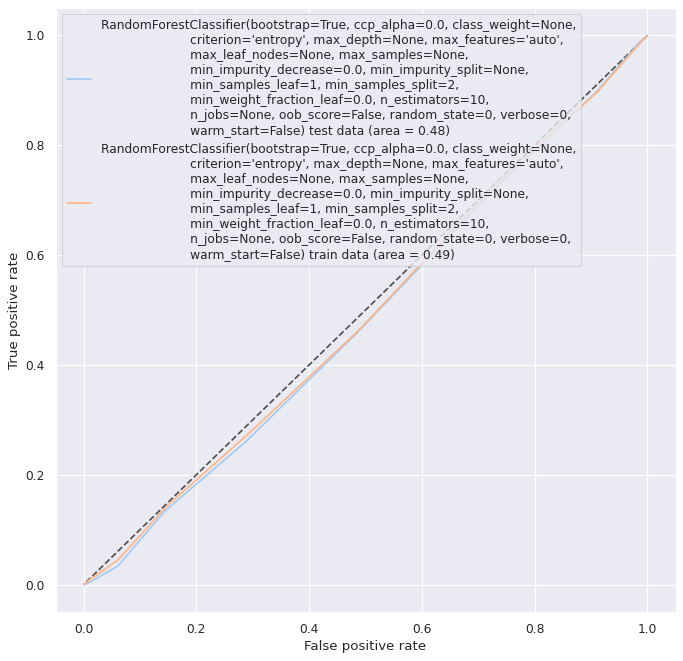

RECALL LDA: 0.812
Accuracy LDA: 0.611


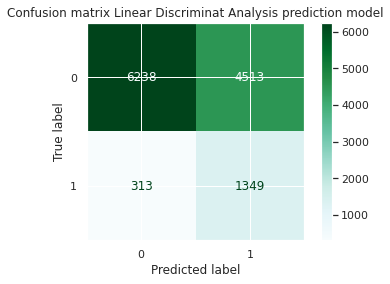

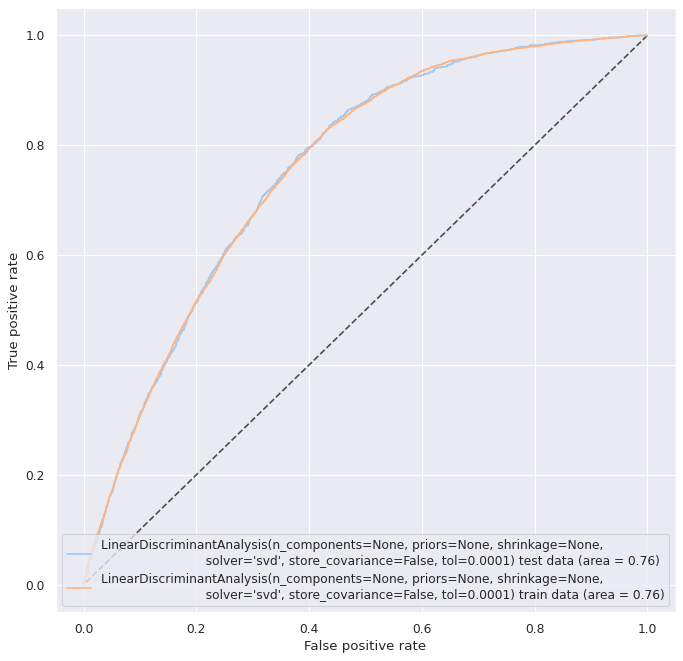

RECALL GBM: 0.983
Accuracy GBM: 0.224


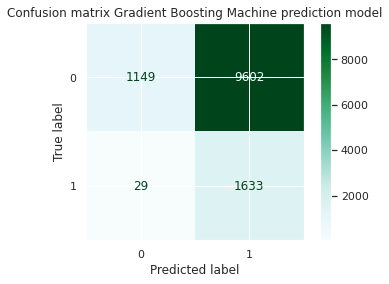

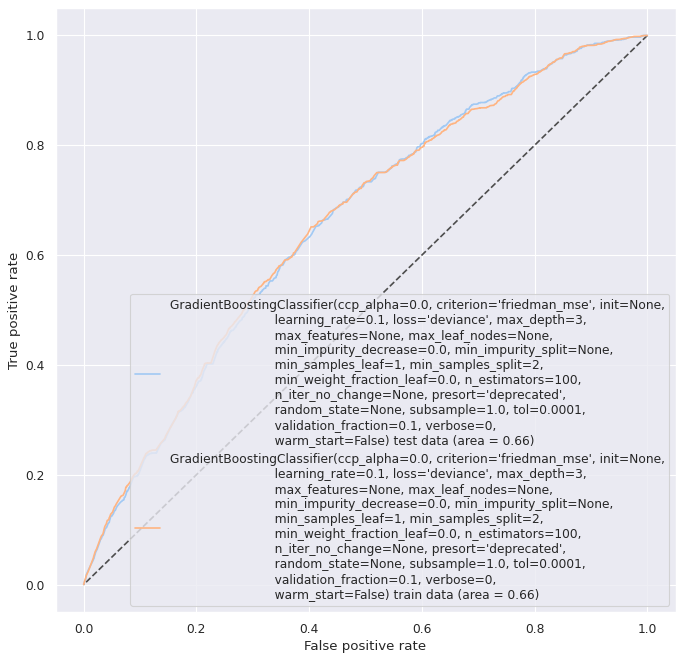

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [121]:
## Naive Bayes 
ypred_nb_pc = (nb_pc.predict_proba(xtest_pc)[:,1]  >= 0.1).astype(bool)
print('RECALL NB: %.3f' % recall_score(ytest_pc, ypred_nb_pc))
print('Accuracy NB: %.3f' % accuracy_score(ytest_pc, ypred_nb_pc))
clear_conf_matrix(ytest_pc, ypred_nb_pc, 'Confusion matrix Naive Bayes prediction model')
roc(ytrain_pc, xtrain_pc, ytest_pc, xtest_pc, nb_pc)


## KNN
ypred_knn_pc = (knn_pc.predict_proba(xtest_pc)[:,1]  >= 0.1).astype(bool)
print('RECALL NB: %.3f' % recall_score(ytest_pc, ypred_knn_pc))
print('Accuracy NB: %.3f' % accuracy_score(ytest_pc, ypred_knn_pc))
clear_conf_matrix(ytest_pc, ypred_knn_pc, 'Confusion matrix K-nearest neighbors prediction model')
roc(ytrain_pc, xtrain_pc, ytest_pc, xtest_pc, knn_pc)

## Logistic regression
yprob_logreg_pc = (logreg_pc.predict_proba(xtest_pc)[:,1]  >= 0.1).astype(bool)
print('RECALL RF: %.3f' % recall_score(ytest_pc, yprob_logreg_pc))
print('Accuracy RF: %.3f' % accuracy_score(ytest_pc, yprob_logreg_pc))
clear_conf_matrix(ytest_pc, yprob_logreg_pc, 'Confusion matrix Logistic regression prediction model')
roc(ytrain_pc, xtrain_pc, ytest_pc, xtest_pc, logreg_pc)

### Random forest

ypred_rfc_pc = (rfc_pc.predict_proba(xtest_pc)[:,1] > 0.1).astype(bool)
print('RECALL RF: %.3f' % recall_score(ytest_pc, ypred_rfc_pc))
print('Accuracy RF: %.3f' % accuracy_score(ytest_pc, ypred_rfc_pc))
clear_conf_matrix(ytest_pc, ypred_rfc_pc, 'Confusion matrix Random Forest prediction model')
roc(ytrain_pc, xtrain_pc, ytest_pc, xtest_pc, rfc_pc)

### LDA

ypred_lda_pc = (lda_pc.predict_proba(xtest_pc)[:,1]  >= 0.1).astype(bool)
print('RECALL LDA: %.3f' % recall_score(ytest_pc, ypred_lda_pc))
print('Accuracy LDA: %.3f' % accuracy_score(ytest_pc, ypred_lda_pc))
clear_conf_matrix(ytest_pc, ypred_lda_pc, 'Confusion matrix Linear Discriminat Analysis prediction model')
roc(ytrain_pc, xtrain_pc, ytest_pc, xtest_pc, lda_pc)


#### GBM
ypred_gbm_pc = (gbm_pc.predict_proba(xtest_pc)[:,1]  >= 0.1).astype(bool)
print('RECALL GBM: %.3f' % recall_score(ytest_pc, ypred_gbm_pc))
print('Accuracy GBM: %.3f' % accuracy_score(ytest_pc, ypred_gbm_pc))
clear_conf_matrix(ytest_pc, ypred_gbm_pc, 'Confusion matrix Gradient Boosting Machine prediction model')
roc(ytrain_pc, xtrain_pc, ytest_pc, xtest_pc, gbm_pc)

